In [3]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.utils import shuffle
from sklearn import set_config, metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, LeaveOneGroupOut, GroupKFold, StratifiedGroupKFold

In [ ]:
sns.set_context("talk")
sns.set_theme(style='white')
sns.set_style("darkgrid")
sns.set_palette('bright')

In [6]:
df_main_author = pd.read_csv(r'../data/ALL_canon_author_scale.csv')
df_main_author.set_index("index", inplace = True)
df_main_author = df_main_author.replace(np.nan, 0)

In [7]:
def get_df_with_authors(df):
    df_res = df.copy()
    list_author = []
    for elem in df_res.index:
        list_author.append(elem.split('_')[1])
    print(len(set(list_author)))
    df_res['auteur'] = list_author
    return df_res

In [8]:
df_main_author = get_df_with_authors(df_main_author)

714


In [9]:
df_unibi_gram_author = df_main_author.iloc[:, 0:2000]
df_unibi_gram_author['canon'] = df_main_author['canon']
df_unibi_gram_author['auteur'] = df_main_author['auteur']

In [10]:
##def plot_coefficients(coefs, feature_names, top_features):
#    top_positive_coefficients = np.argsort(coefs)[-top_features:]
#    top_negative_coefficients = np.argsort(coefs)[:top_features]
#    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
#    # create plot
#    plt.figure(figsize=(15, 5))
#    colors = ['canon' if c < 0 else 'non_canon' for c in coefs[top_coefficients]]
#    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
#    feature_names = np.array(feature_names)
#    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
#    plt.title("Best classification coefficients")
#    #plt.savefig('../img/coefs_linear_svm_canon_novels.png', format='png', bbox_inches='tight', dpi=400)
#
#    plt.show()

In [16]:
def plot_coefficients(coefs, feature_names, top_features):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    fig, ax = plt.subplots(figsize=(15, 5))

    colors = ['canon' if c < 0 else 'non_canon' for c in coefs[top_coefficients]]
    feature_names = np.array(feature_names)
    zipped = list(zip(feature_names, coefs[top_coefficients], colors))
    df_tmp = pd.DataFrame(zipped, columns=['features', 'coefs', 'colors'])
    
    sns.barplot(data=df_tmp, x='features', y='coefs', color=colors, ax=ax, hue='colors', palette=sns.color_palette())

    ax.set_xlabel('Feature name', fontsize = 30)
    ax.set_ylabel('Coefficient score', fontsize = 30)
    
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    #plt.title("Best classification coefficients")
    plt.savefig('../img/coefs_linear_svm_canon_novels.png', format='png', bbox_inches='tight', dpi=400)

    plt.show()
    


In [69]:
def GKF_canonized(df_main, n_splits=5, probas=False, kernel='rbf'):
    
    ALL_PREDS, ALL_GT = [], [] # lists of all predictions vs all ground truth data
    ALL_PROBAS, ALL_INDEX = [], [] # lists of all test probas and all test index
    
    pipe = make_pipeline(StandardScaler(), SVC(class_weight="balanced", probability=probas, kernel=kernel))#{"canon":10, "non_canon":1}
    gkf = GroupKFold(n_splits)
    
    for (train_index, test_index) in gkf.split(df_main.drop(['auteur', 'canon'], axis=1), df_main['canon'], df_main['auteur']): 
            train = df_main.iloc[train_index]
            test = df_main.iloc[test_index]

            X_train = train.drop(['auteur', 'canon'], axis=1)
            y_train = train['canon']
            X_test = test.drop(['auteur', 'canon'], axis=1)
            y_test = test['canon']
            
            pipe.fit(X_train, y_train)               
            preds = pipe.predict(X_test)
            
            ALL_PREDS.extend(preds)
            ALL_GT.extend(y_test)
            ALL_INDEX.extend(X_test.index)
                        
            if probas==True:
                probs = pipe.predict_proba(X_test)[:,0]
                ALL_PROBAS.extend(probs)

            
    _ = ConfusionMatrixDisplay.from_predictions(ALL_GT, ALL_PREDS)

    bas = balanced_accuracy_score(ALL_GT, ALL_PREDS)
    report = metrics.classification_report(ALL_GT, ALL_PREDS, output_dict=True)# zero_division=1
    df_scores = pd.DataFrame(report).transpose().drop(['macro avg', 'weighted avg'])
    #print(df_scores)
    print(bas)
    
    if kernel == 'linear':
        coefs = pipe.named_steps['svc'].coef_
        df_coefs = pd.DataFrame(coefs, columns=X_train.columns)
        df_coefs.to_csv("../outputs/outputs_SVM_GFK/coefs_novel_scale.csv")
        plot_coefficients(*coefs, X_train.columns, 20)
        return pipe, df_scores, bas, df_coefs
    
    if probas==True:
        df_results = pd.DataFrame()
        
        df_results['metadata'] = ALL_GT
        df_results['proba_canon'] = ALL_PROBAS
        df_results['prediction']= ALL_PREDS
        df_results['index']= ALL_INDEX
        df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
        
        return pipe, df_scores, bas, df_results.set_index('index')

    return pipe, df_scores, bas

0.740695923146758


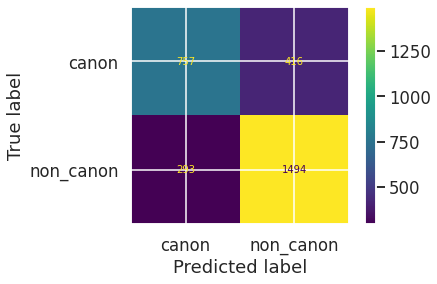

In [70]:
pipe, df_scores, bas, df_results = GKF_canonized(df_unibi_gram_author, probas=True)

In [39]:
df_scores

,precision,recall,f1-score,support
canon,0.720952,0.645354,0.681062,1173.000000
non_canon,0.782199,0.836038,0.808223,1787.000000
accuracy,0.760473,0.760473,0.760473,0.760473


In [40]:
df_results.to_csv('../outputs/outputs_SVM_GFK/output_GKF_canonizer_author_scale.csv', index=True)

In [41]:
bas

0.740695923146758

In [14]:
df_final_scores

,precision,recall,f1-score,support
canon,0.720952,0.645354,0.681062,1173.000000
non_canon,0.782199,0.836038,0.808223,1787.000000
accuracy,0.760473,0.760473,0.760473,0.760473


In [35]:
print(df_final_scores.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
canon     &      0.721 &   0.645 &     0.681 & 1173.000 \\
non\_canon &      0.782 &   0.836 &     0.808 & 1787.000 \\
accuracy  &      0.760 &   0.760 &     0.760 &    0.760 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5221/3649009022.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_final_scores.to_latex(float_format="%.3f"))


In [154]:
joblib.dump(pipe, 'pipes/pipeline_author_scale.pkl')

['pipes/pipeline_author_scale.pkl']

0.6592523630215571


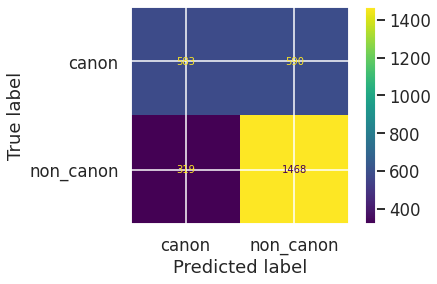

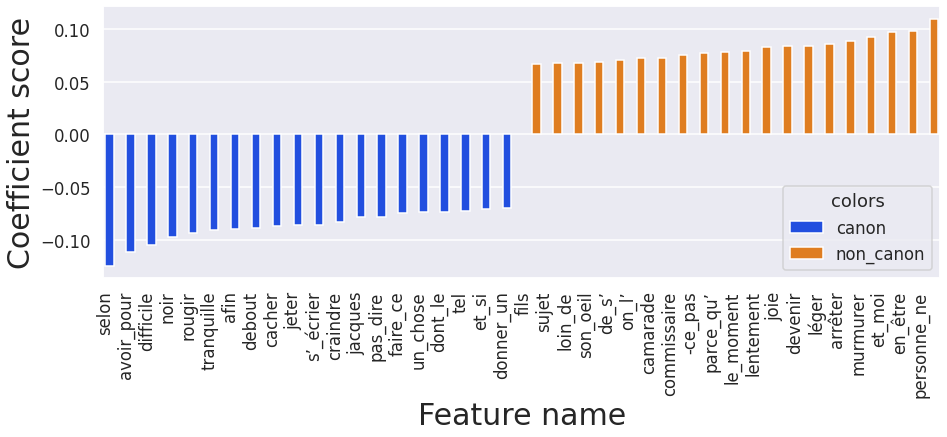

In [30]:
pipe, df_scores, bas, df_coefs = GKF_canonized(df_unibi_gram_author, kernel='linear')

In [31]:
df_coefs.to_csv('../outputs/outputs_SVM_GFK/coefs_author_scale.csv', header=True, index=False)

## NOVEL SCALE

In [71]:
def ratio_truncate(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = df_res.canon.value_counts(normalize=True).canon
    index_noncanon = df_res[df_res['canon']  == 'non_canon'].index 
    i, j = 0, 20
    
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=10
        ratio_temp = df_res.canon.value_counts(normalize=True).canon

    return shuffle(df_res)

In [72]:
def N_canonizer_sizeopti(df_main, N_fold=5, N_sample=10, ratio=0.5):
    list_res, all_bas = [], []
    for i in tqdm(range(N_sample)):
        df_sizeopti_last = ratio_truncate(df_main, ratio)
        pipe, results, bas = GKF_canonized(df_sizeopti_last, N_fold)
        list_res.append(results)
        all_bas.append(bas)
    all_results = pd.concat(list_res).groupby(level=0).mean()
    print(sum(all_bas)/len(all_bas))
    return pipe, all_results, all_bas # return last pipe

In [20]:
df_main_novel = pd.read_csv(r'../data/ALL_canon_novel_scale.csv')
df_main_novel.set_index("index", inplace = True)
df_main_novel = df_main_novel.replace(np.nan, 0)

In [21]:
df_main_novel = get_df_with_authors(df_main_novel)

714


In [22]:
df_unibi_gram_novel = df_main_novel.iloc[:, 0:2000]
df_unibi_gram_novel['canon']=df_main_novel['canon']
df_unibi_gram_novel['auteur'] = df_main_novel['auteur']

In [73]:
df_sizeopti_novel = ratio_truncate(df_unibi_gram_novel, 0.5)

0.7264254385964912


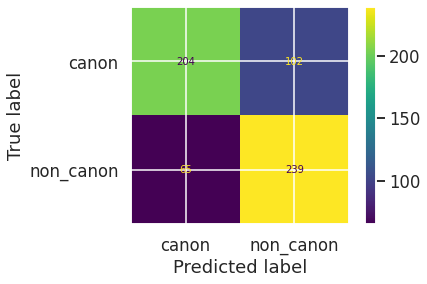

In [74]:
pipe, df_scores, bas, df_results = GKF_canonized(df_sizeopti_novel, probas=True)

In [75]:
df_scores

,precision,recall,f1-score,support
canon,0.758364,0.666667,0.709565,306.00000
non_canon,0.700880,0.786184,0.741085,304.00000
accuracy,0.726230,0.726230,0.726230,0.72623


In [53]:
df_scores

,precision,recall,f1-score,support
canon,0.740876,0.663399,0.700000,306.00
non_canon,0.684049,0.758503,0.719355,294.00
accuracy,0.710000,0.710000,0.710000,0.71


In [33]:
df_results

,metadata,proba_canon,prediction,accord
index,,,,
1884_Gouraud-Julie_La-petite-maîtresse-de-maison,non_canon,0.250677,non_canon,True
1923_Radiguet-Raymond_Le-diable-au-corps,canon,0.429209,non_canon,False
1832_Mere-Elisabeth-Brossin-de_Le-Parc-aux-Cerfs-ou-Histoire-secrete-des-jeunes-demoiselles-qui-y-ont-ete-renfermees_(tome-3),non_canon,0.195296,non_canon,True
1936_Aragon-Louis_Les-Beaux-Quartiers,canon,0.901146,canon,True
1842_Balzac-Honore-de_La-Femme-de-trente-ans,canon,0.131692,non_canon,False
...,...,...,...,...
2008_Enard-Mathias_Zone,canon,0.863711,canon,True
1846_Sand-George_La-Mare-au-Diable,canon,0.189735,non_canon,False
1991_Combescot-Pierre_Les-filles-du-Calvaire,canon,0.818652,canon,True


In [34]:
df_results.to_csv('../outputs/outputs_SVM_GFK/output_GKF_canonizer_novel_scale.csv', index=True)

  0%|          | 0/100 [00:00<?, ?it/s]

0.7309590502867813
0.7141523275977057
0.7056489262371616
0.7061824729891957
0.6895758303321329
0.6962451647325596
0.7041483259970656
0.711017740429505
0.7256569294384421
0.6908096571962119
0.6944110977724423
0.7127851140456183
0.7157863145258103
0.6960450847005469
0.7101507269574496
0.7138188608776844
0.6858410030678939
0.6924436441243165
0.7123182606375884
0.6976790716286515


/home/crazyjeannot/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


0.6957783113245298
0.7300253434707216
0.7156529278378019
0.7023809523809523
0.6690342803788182
0.7125183406696012
0.7106842737094838
0.6923769507803121
0.6927771108443377
0.6609310390822996
0.6943444044284381
0.6925103374683207
0.6822395624916633
0.6891756702681073
0.7223889555822329
0.736594637855142
0.7239562491663332
0.695578231292517
0.7137521675336802
0.6859076964118981
0.7195211417900493
0.7223222622382286
0.6638655462184874
0.7041483259970656
0.6973456049086302
0.7153194611177804
0.6765372815792984
0.7038815526210485
0.71421902094171
0.702514339068961
0.6957783113245298
0.6857076163798853
0.6926437241563292
0.6957783113245298
0.7074162998532747
0.7128518073896225
0.6889755902360944
0.7029144991329865
0.702781112444978
0.6974122982526344
0.6823062558356676
0.680672268907563
0.7009470454848606
0.7208216619981326
0.6986461251167133
0.7223889555822329
0.7107509670534882
0.694077631052421
0.6771375216753368
0.711017740429505
0.7077497665732959
0.6778044551153795
0.6706015739629185
0.

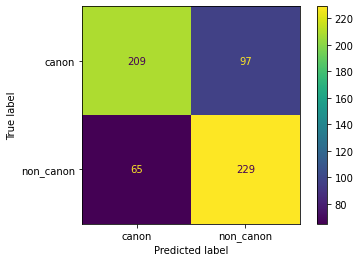

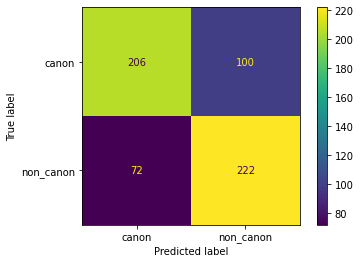

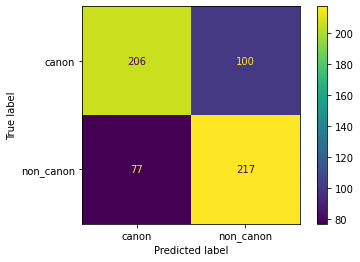

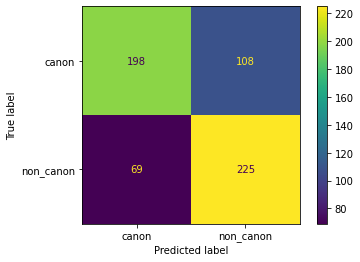

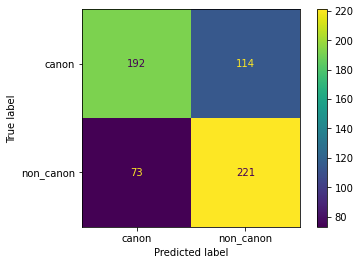

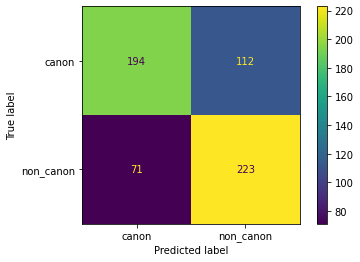

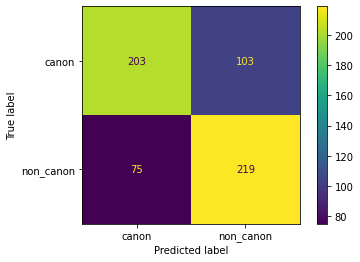

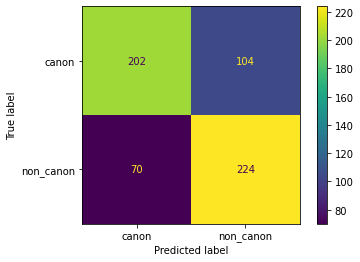

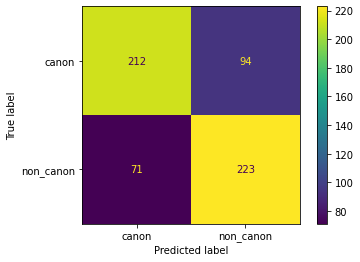

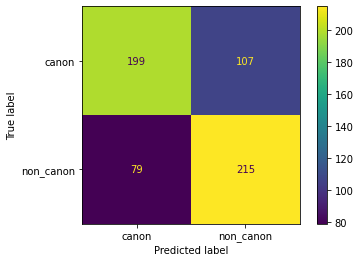

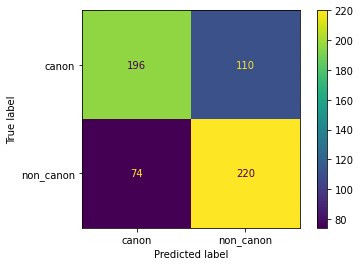

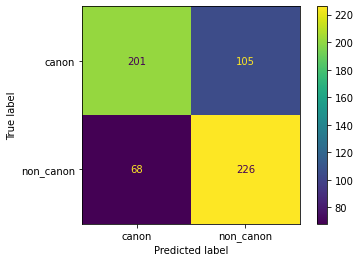

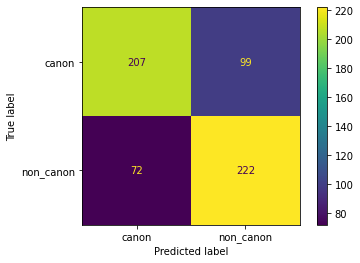

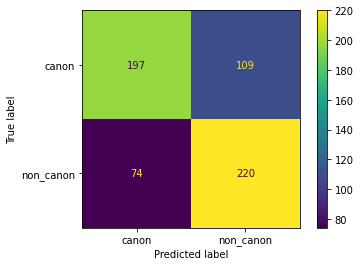

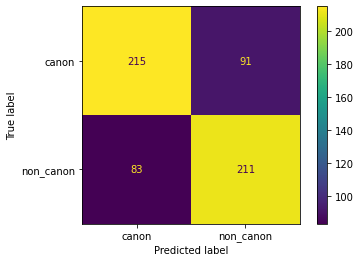

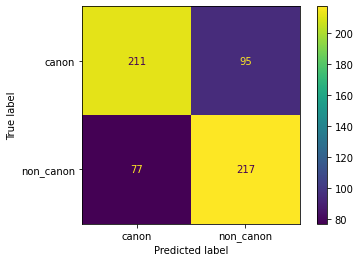

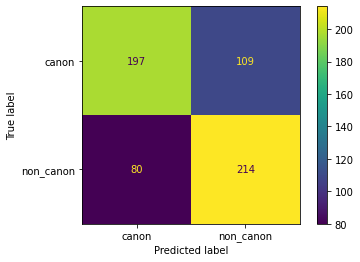

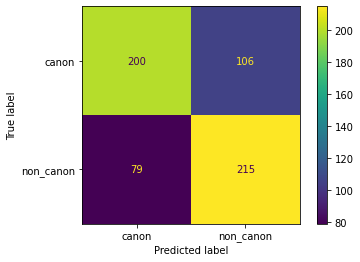

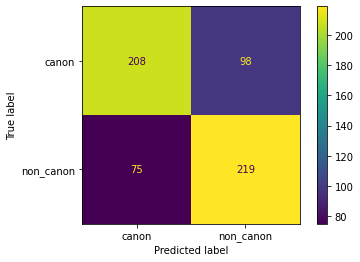

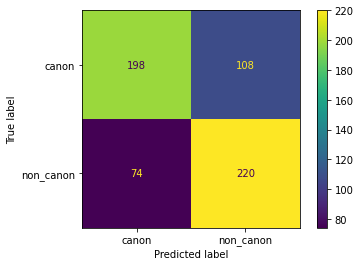

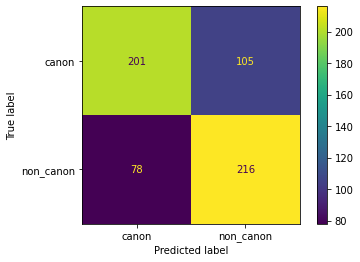

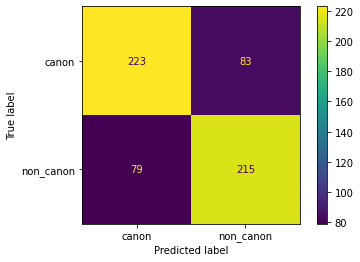

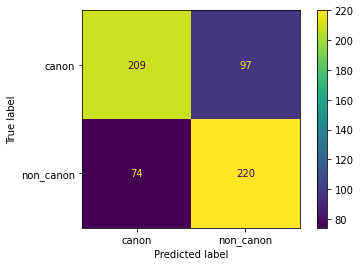

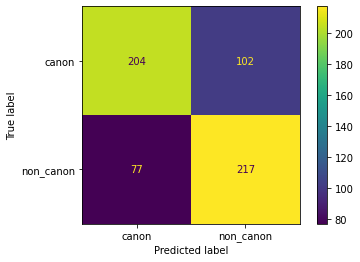

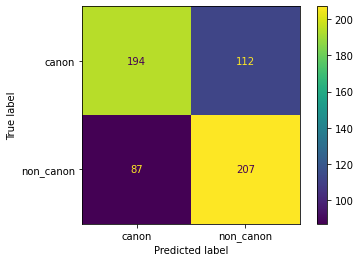

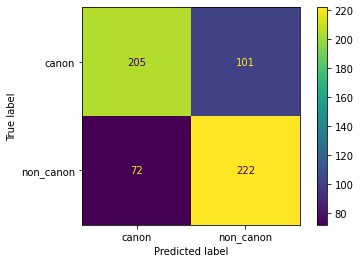

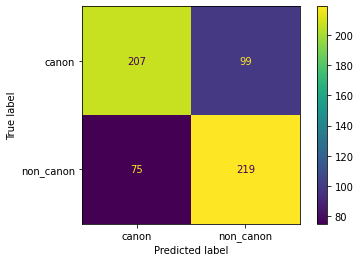

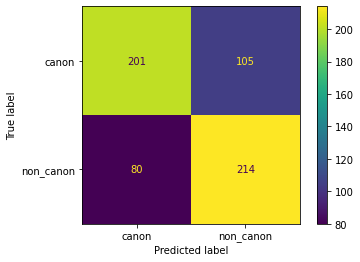

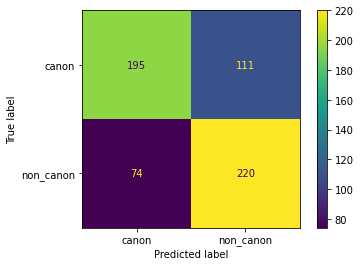

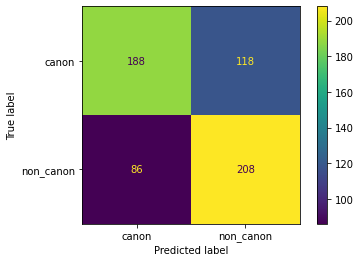

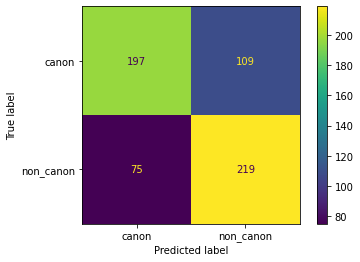

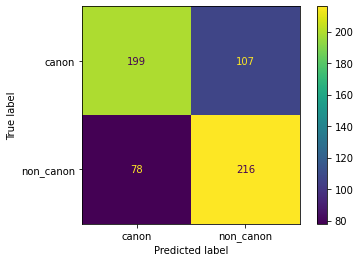

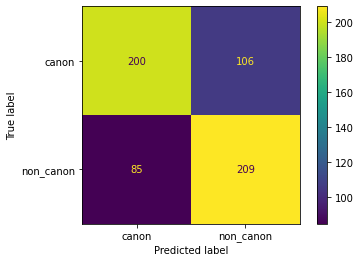

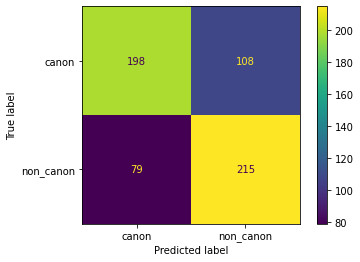

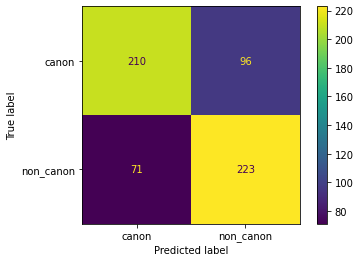

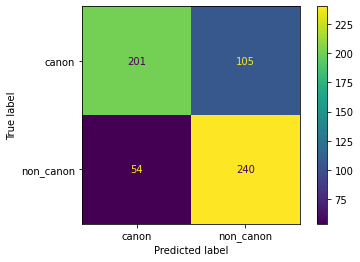

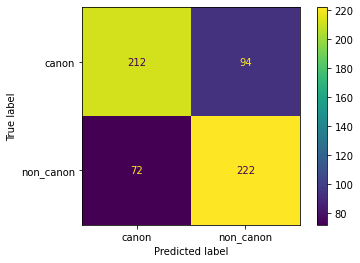

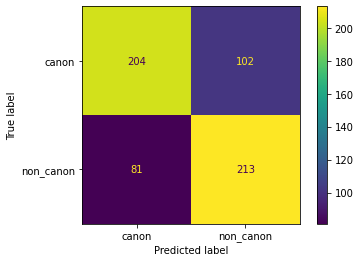

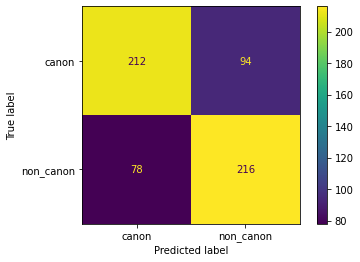

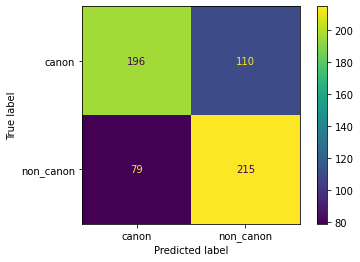

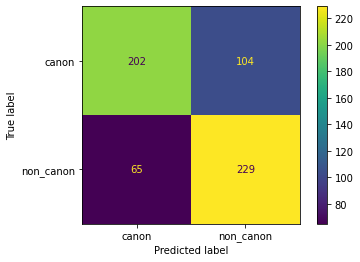

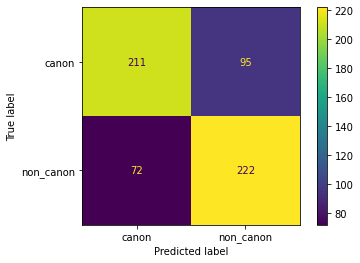

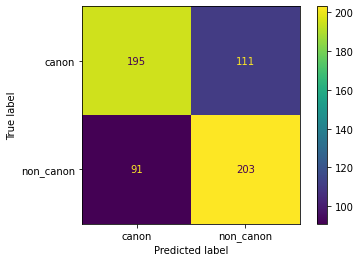

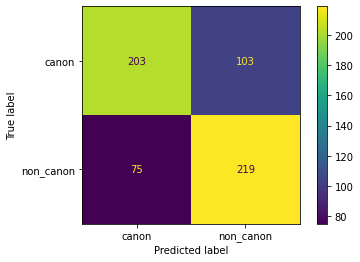

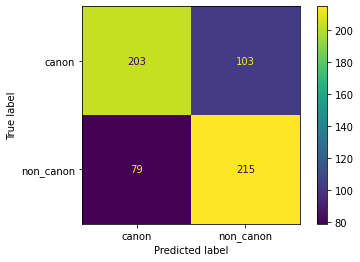

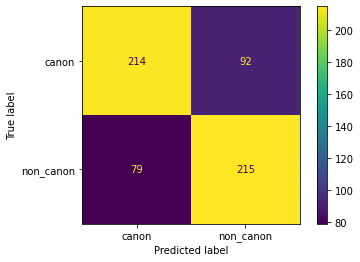

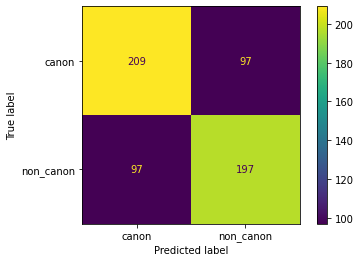

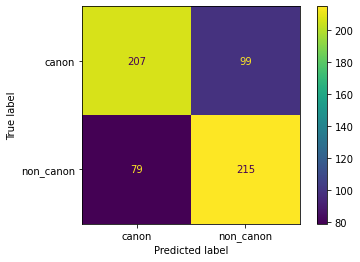

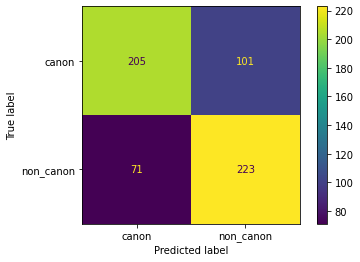

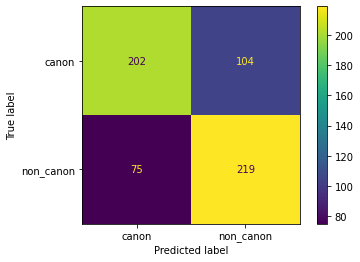

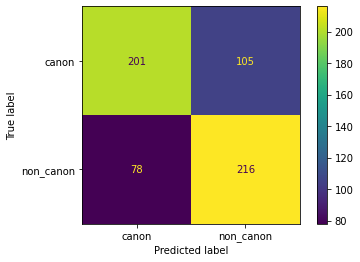

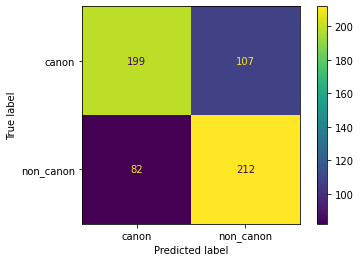

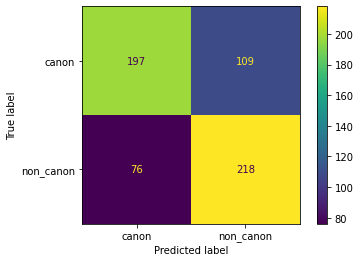

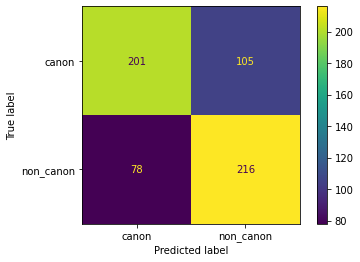

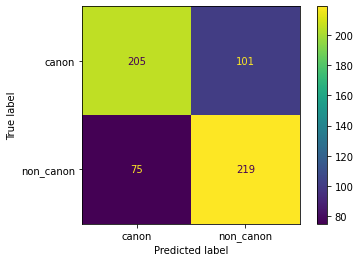

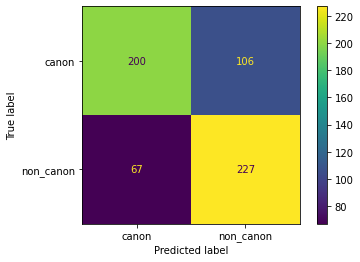

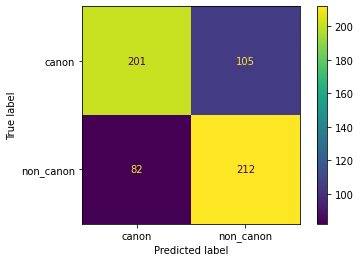

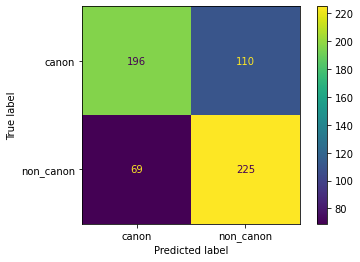

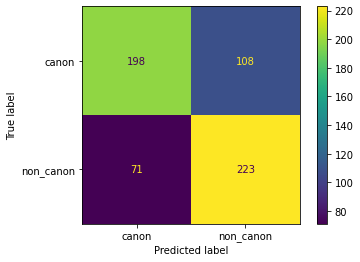

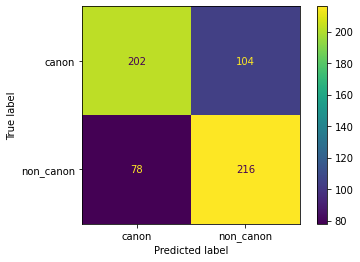

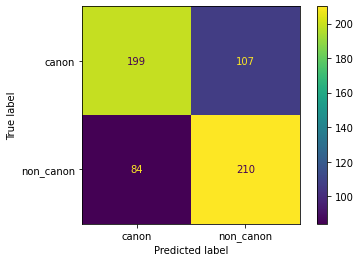

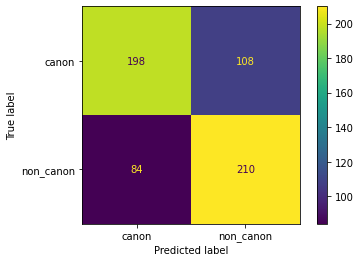

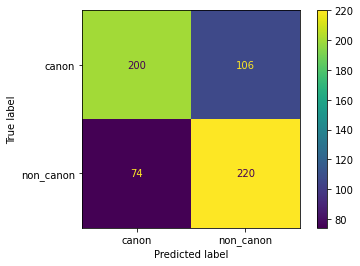

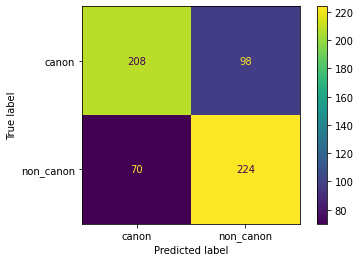

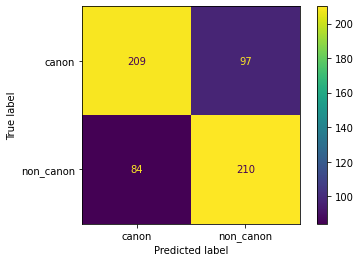

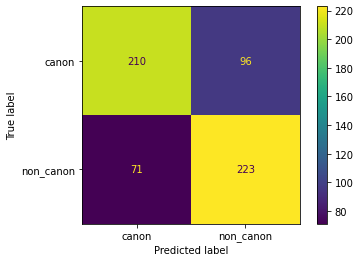

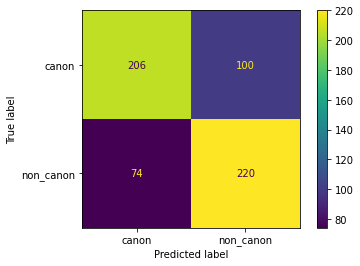

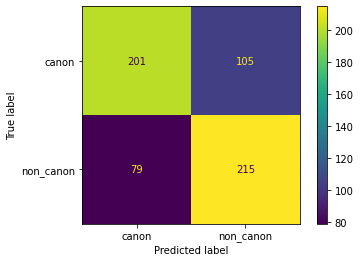

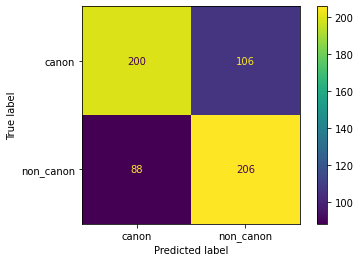

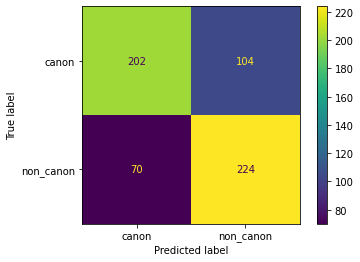

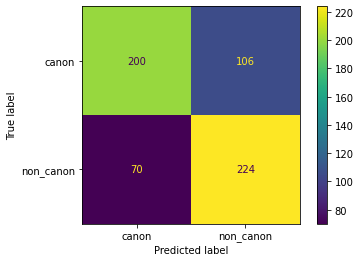

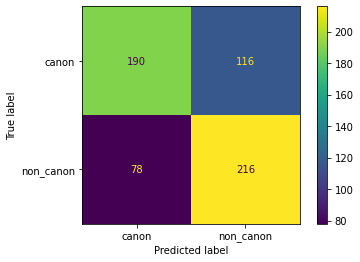

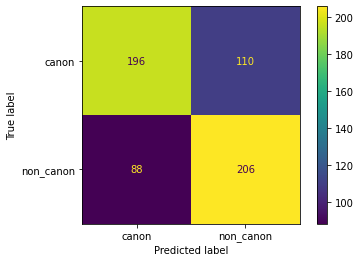

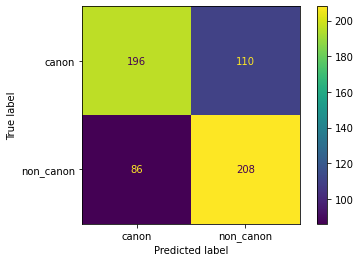

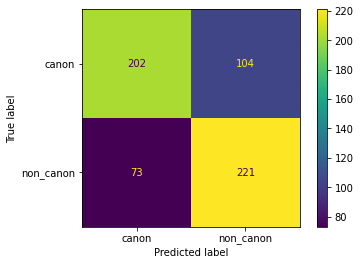

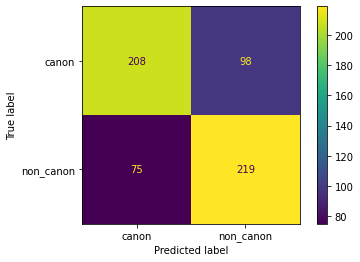

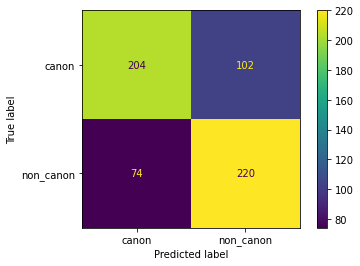

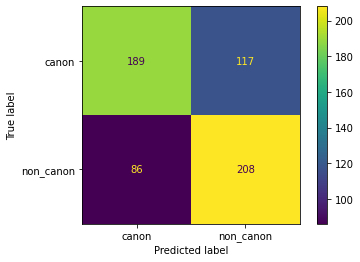

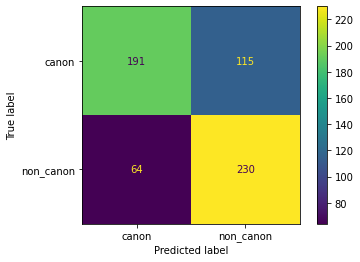

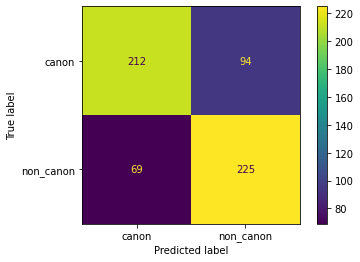

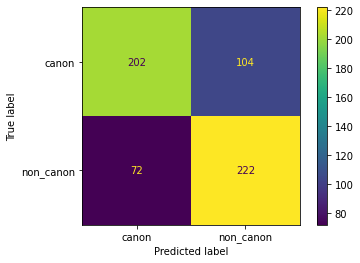

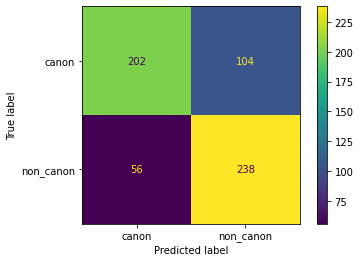

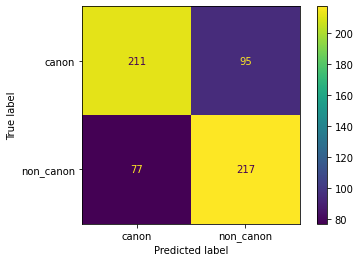

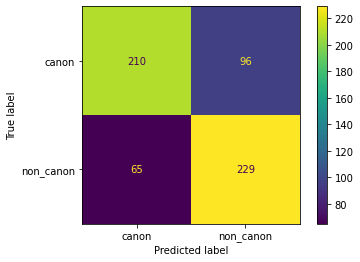

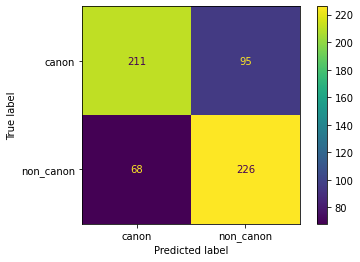

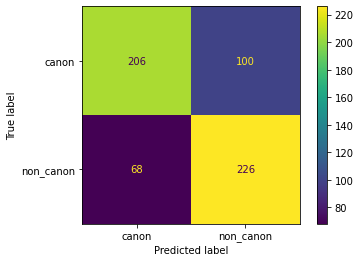

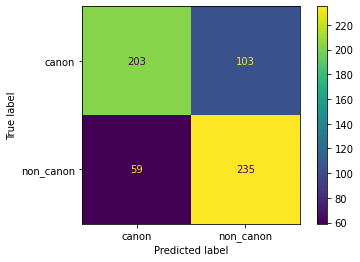

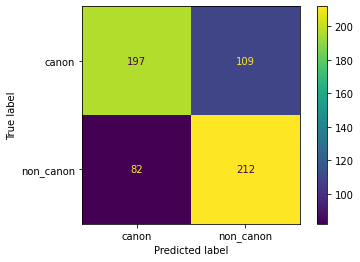

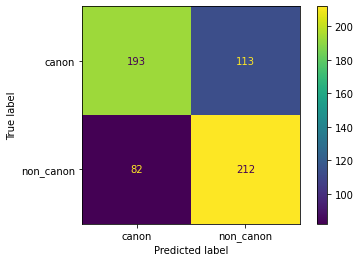

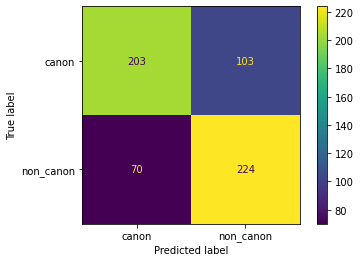

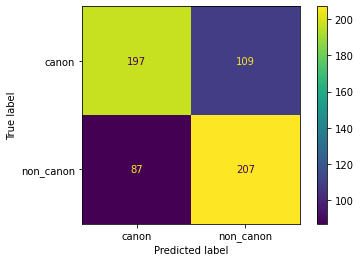

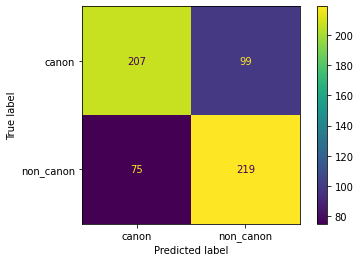

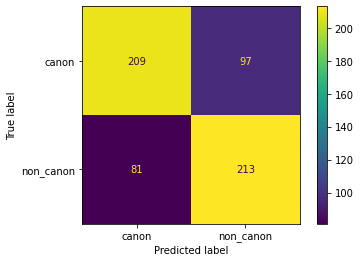

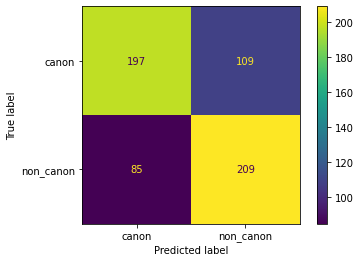

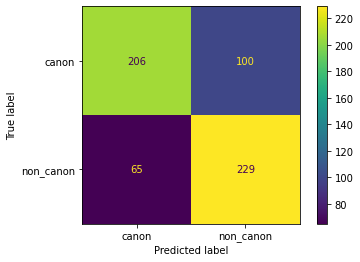

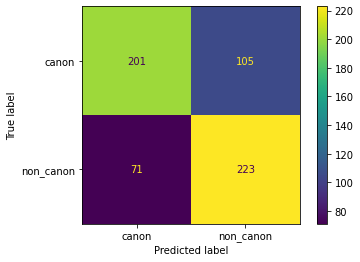

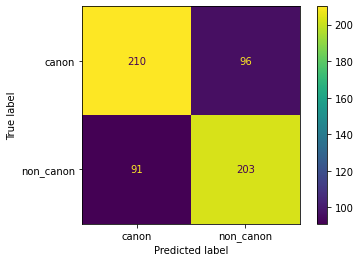

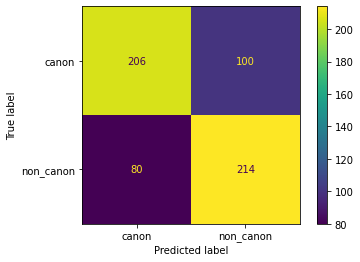

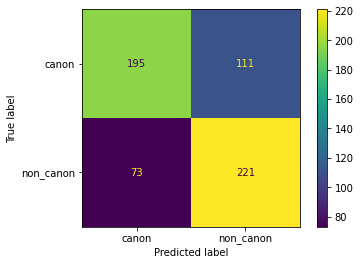

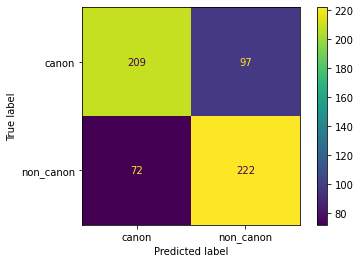

In [27]:
pipe, res, all_bas = N_canonizer_sizeopti(df_unibi_gram_novel, N_sample=100, ratio=0.5)

In [29]:
res

,precision,recall,f1-score,support
accuracy,0.701383,0.701383,0.701383,0.701383
canon,0.728222,0.661895,0.693303,306.000000
non_canon,0.678521,0.742483,0.708929,294.000000


In [30]:
sum(all_bas)/len(all_bas)

0.7021892090169402

In [31]:
print(res.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
accuracy & 0.701 & 0.701 & 0.701 & 0.701 \\
canon & 0.728 & 0.662 & 0.693 & 306.000 \\
non_canon & 0.679 & 0.742 & 0.709 & 294.000 \\
\bottomrule
\end{tabular}



In [342]:
res

,precision,recall,f1-score,support
accuracy,0.708824,0.708824,0.708824,0.708824
canon,0.696100,0.626797,0.659355,306.000000
non_canon,0.717851,0.775936,0.745619,374.000000


In [32]:
res

,precision,recall,f1-score,support
accuracy,0.701383,0.701383,0.701383,0.701383
canon,0.728222,0.661895,0.693303,306.000000
non_canon,0.678521,0.742483,0.708929,294.000000


In [46]:
joblib.dump(pipe, 'pipes/pipeline_novel_scale.pkl')

['pipes/pipeline_novel_scale.pkl']

0.6389555822328932


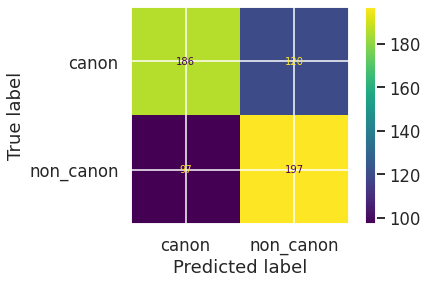

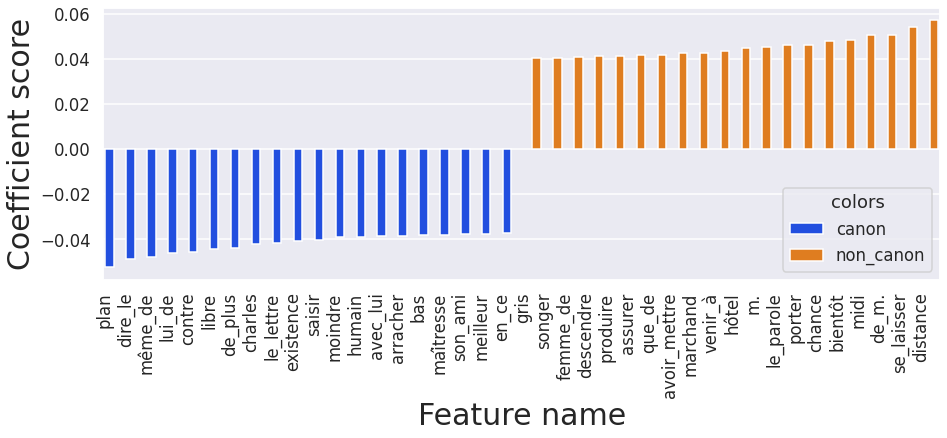

In [25]:
pipe, df_scores, bas, df_coefs = GKF_canonized(df_sizeopti_novel, kernel='linear')

In [27]:
df_coefs.to_csv('../outputs/outputs_SVM_GFK/coefs_novel_scale.csv', header=True, index=False)

In [28]:
df_coefs

,le,de,un,et,il,avoir,à,lui,être,son,...,ni_le,l’_argent,faire_pour,le_vérité,mais_à,ça_ne,le_feu,avoir_je,j’_aller,le_nature
0,0.005352,0.01855,0.002772,-0.002875,-0.00476,-0.00114,-0.006477,-0.004449,-0.004548,-0.000332,...,-0.025049,-0.006159,-0.024898,0.007807,-0.001225,0.010229,-0.001443,0.003244,0.013834,-0.02202


In [29]:
pipe.classes_

array(['canon', 'non_canon'], dtype=object)

### TRY SCOLAIRE/NON-SCOLAIRE CANON

In [56]:
df_unibi_gram_scolaire = pd.read_csv('meta_data/uni_bi_gram_scolaire.csv')
df_unibi_gram_scolaire.set_index("index", inplace = True)
df_unibi_gram_scolaire = df_unigram_scolaire.replace(np.nan, 0)

In [57]:
df_unibi_gram_scolaire = get_df_with_authors(df_unibi_gram_scolaire)

714


  0%|          | 0/10 [00:00<?, ?it/s]

0.5720306513409962
0.6139208173690933
0.6375478927203064
0.6282247765006386
0.6634738186462323
0.5985951468710089
0.683397190293742
0.6515964240102171
0.5988505747126436
0.657471264367816


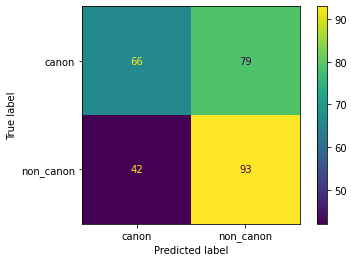

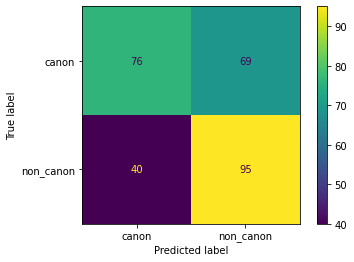

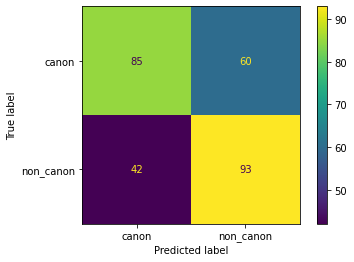

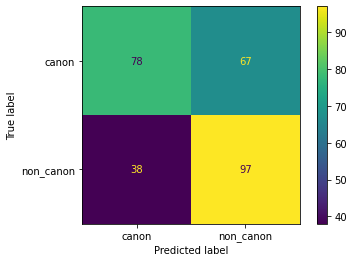

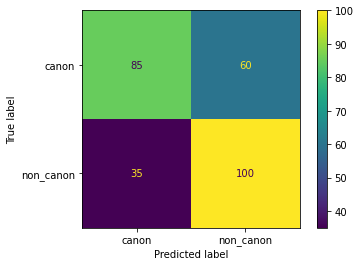

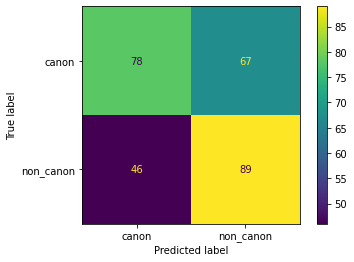

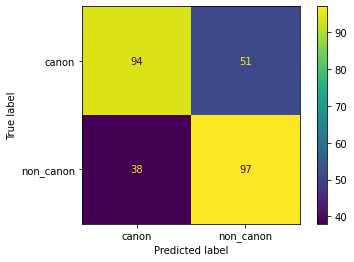

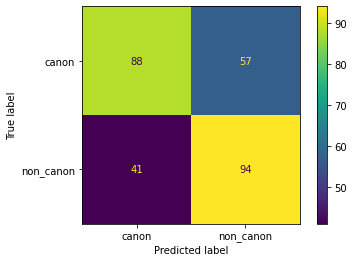

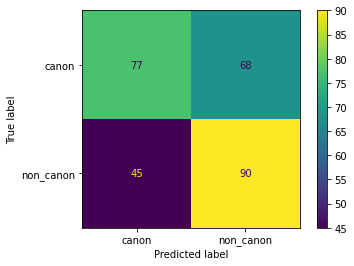

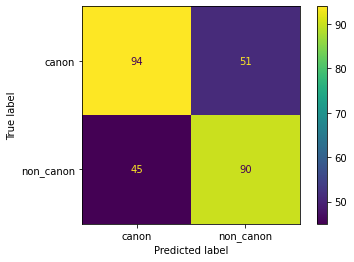

In [58]:
pipe, res, all_bas = N_canonizer_sizeopti(df_unibi_gram_scolaire, N_sample=10, ratio=0.5)

In [59]:
res

,precision,recall,f1-score,support
accuracy,0.628214,0.628214,0.628214,0.628214
canon,0.664705,0.566207,0.610804,145.000000
non_canon,0.600063,0.694815,0.643499,135.000000


In [60]:
sum(all_bas)/len(all_bas)

0.6305108556832694

In [61]:
df_unibi_gram_non_scolaire = pd.read_csv('meta_data/uni_bi_gram_non_scolaire.csv')
df_unibi_gram_non_scolaire.set_index("index", inplace = True)
df_unibi_gram_non_scolaire = df_unibi_gram_non_scolaire.replace(np.nan, 0)

In [62]:
df_unibi_gram_non_scolaire = get_df_with_authors(df_unibi_gram_non_scolaire)

714


  0%|          | 0/10 [00:00<?, ?it/s]

0.7119307400379506
0.717741935483871
0.7363614800759013
0.6820445920303606
0.6860768500948766
0.7084914611005693
0.7051707779886148
0.7191650853889944
0.6967504743833017
0.728296963946869


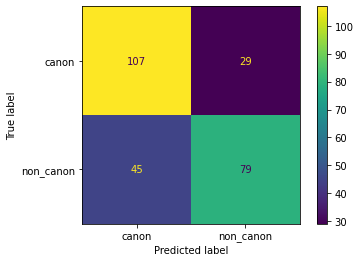

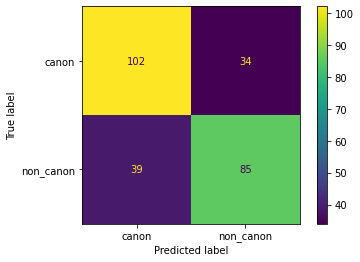

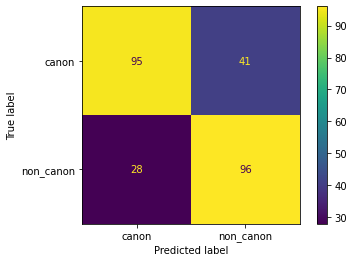

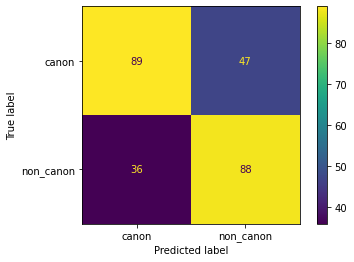

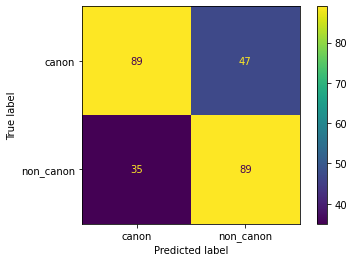

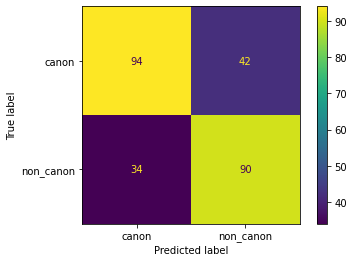

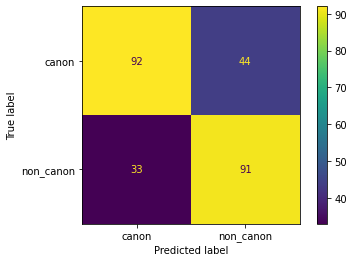

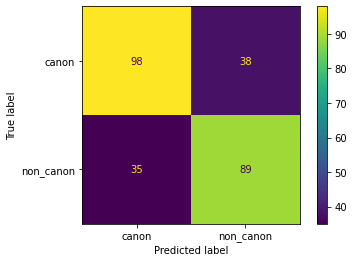

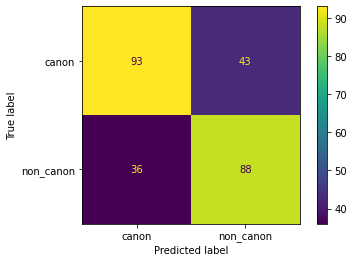

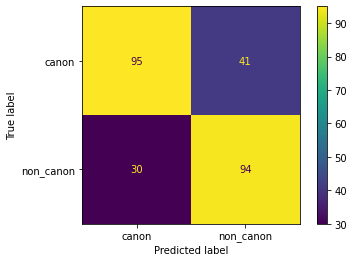

In [63]:
pipe, res, all_bas = N_canonizer_sizeopti(df_unibi_gram_non_scolaire, N_sample=10, ratio=0.5)

In [64]:
res

,precision,recall,f1-score,support
accuracy,0.708846,0.708846,0.708846,0.708846
canon,0.731760,0.701471,0.715530,136.000000
non_canon,0.687749,0.716935,0.701146,124.000000


In [65]:
sum(all_bas)/len(all_bas)

0.709203036053131

### BASELINES - 

- RANDOM BUT 60% non_canon, 40% canon (author scale)

- RANDOM BUT 90% non_canon, 10% canon (novel scale)

In [327]:
df_canon_random_author = df_unibi_gram_author.drop(['canon'], axis=1)
df_canon_random_novel = df_unibi_gram_novel.drop(['canon'], axis=1)

In [328]:
df_canon_random_author['canon'] = random.choices(['canon', 'non_canon'], weights = [1, 1.5], k = len(df_canon_random_author))
df_canon_random_novel['canon'] = random.choices(['canon', 'non_canon'], weights = [1, 9], k = len(df_canon_random_novel))

In [329]:
pipe_author, scores_author, bas = GKF_canonized(df_canon_random_author)

0.4853260589194738


In [345]:
scores_author

,precision,recall,f1-score,support
canon,0.364004,0.316067,0.338346,1139.000000
non_canon,0.604769,0.654585,0.628692,1821.000000
accuracy,0.524324,0.524324,0.524324,0.524324


In [346]:
pipe, scores, all_bas = N_canonizer_sizeopti(df_canon_random_novel, ratio=0.45)

  0%|          | 0/10 [00:00<?, ?it/s]

0.5033758145133855
0.48691544762253686
0.5241279145840421
0.49931088024145365
0.5133462434250124
0.5014654698662758
0.5481162606093912
0.5208742225595129
0.5195570442868483
0.46883695775434187


In [347]:
scores

,precision,recall,f1-score,support
accuracy,0.511324,0.511324,0.511324,0.511324
canon,0.463004,0.478641,0.469901,309.000000
non_canon,0.554062,0.538544,0.545455,371.000000


In [348]:
sum(all_bas)/len(all_bas)

0.50859262554628

### TRY run 7 models, 1 each 30 years

In [34]:
df_unibi_gram_author = df_main_author.iloc[:, 0:2000]
df_unibi_gram_author['canon'] = df_main_author['canon']
df_unibi_gram_author['auteur'] = df_main_author['auteur']

In [36]:
def get_date(df):
    df_res = df.copy()
    list_date = []
    for elem in df_res.index:
        list_date.append(int(str(elem)[:4]))
    df_res['date'] = list_date
    return df_res

In [37]:
df_unibi_gram_author_dated = get_date(df_unibi_gram_author)

In [47]:
df_author_1810_1840 = df_unibi_gram_author_dated.loc[(df_unibi_gram_author_dated['date']>=1810) & (df_unibi_gram_author_dated['date']<1840)]
df_author_1840_1870 = df_unibi_gram_author_dated.loc[(df_unibi_gram_author_dated['date']>=1840) & (df_unibi_gram_author_dated['date']<1870)]
df_author_1870_1900 = df_unibi_gram_author_dated.loc[(df_unibi_gram_author_dated['date']>=1870) & (df_unibi_gram_author_dated['date']<1900)]
df_author_1900_1930 = df_unibi_gram_author_dated.loc[(df_unibi_gram_author_dated['date']>=1900) & (df_unibi_gram_author_dated['date']<1930)]
df_author_1930_1960 = df_unibi_gram_author_dated.loc[(df_unibi_gram_author_dated['date']>=1930) & (df_unibi_gram_author_dated['date']<1960)]
df_author_1960_1990 = df_unibi_gram_author_dated.loc[(df_unibi_gram_author_dated['date']>=1960) & (df_unibi_gram_author_dated['date']<1990)]
df_author_1990_2020 = df_unibi_gram_author_dated.loc[(df_unibi_gram_author_dated['date']>=1990) & (df_unibi_gram_author_dated['date']<2020)]

0.6682098765432098


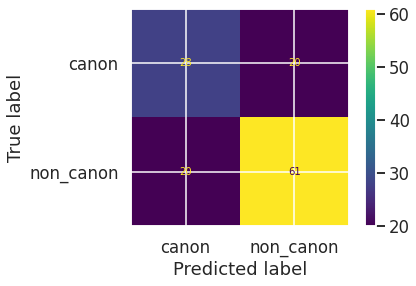

In [48]:
pipe1, df_scores1, bas1 = GKF_canonized(df_author_1810_1840)

In [59]:
df_author_1840_1870.canon.value_counts()

canon
non_canon    328
canon        263
Name: count, dtype: int64

0.48919016043772606


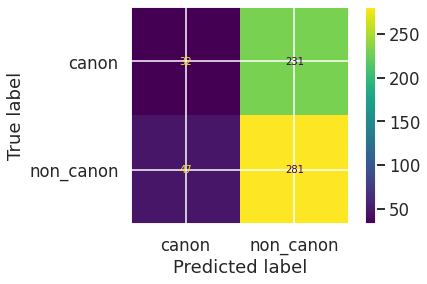

In [53]:
pipe3, df_scores3, bas3 = GKF_canonized(df_author_1840_1870)

0.6584660033167495


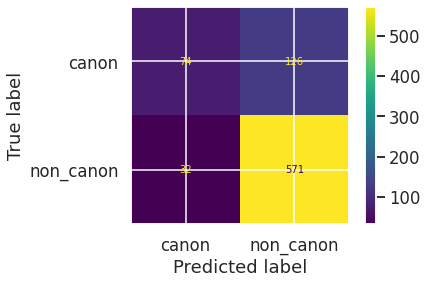

In [52]:
pipe, df_scores, bas = GKF_canonized(df_author_1870_1900)

0.7530516078903176


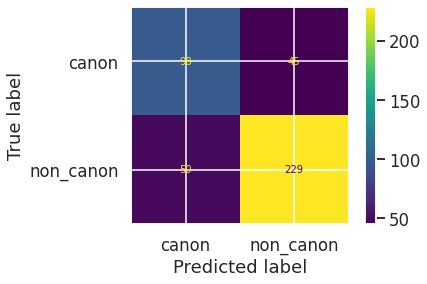

In [54]:
pipe4, df_scores4, bas4 = GKF_canonized(df_author_1900_1930)

0.693075241520344


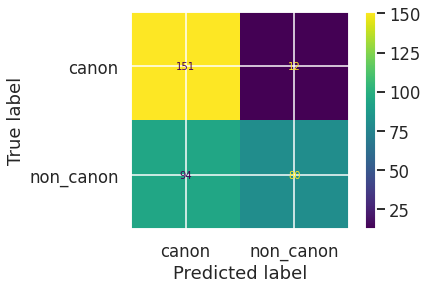

In [55]:
pipe4, df_scores4, bas4 = GKF_canonized(df_author_1930_1960)

0.7819603753910322


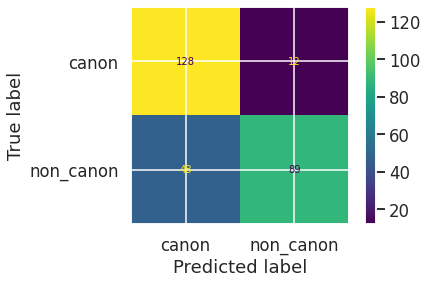

In [56]:
pipe4, df_scores4, bas4 = GKF_canonized(df_author_1960_1990)

0.7055631451123254


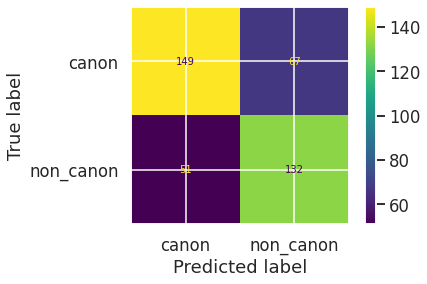

In [57]:
pipe4, df_scores4, bas4 = GKF_canonized(df_author_1990_2020)

### DOC2VEC 

#### w/ pretrained model

In [28]:
df_main = pd.read_csv(r'data_doc2vec/spacy_vectors.csv')

In [29]:
df_main.set_index("Unnamed: 0", inplace = True)
df_main = df_main.replace(np.nan, 0)

In [34]:
df_main_author = get_df_with_authors(df_main)

714


In [22]:
df_canon_NOVEL_SCALE = pd.read_csv(r'meta_data/df_canon_NOVEL_SCALE.csv').drop(['Unnamed: 0'], axis=1)
df_canon_NOVEL_SCALE.set_index("doc_name", inplace = True)

In [23]:
df_canon_AUTEUR_SCALE = pd.read_csv(r'meta_data/df_canon_AUTEUR_SCALE.csv').drop(['Unnamed: 0'], axis=1)
df_canon_AUTEUR_SCALE.set_index("doc_name", inplace = True)

In [24]:
df_canon_NOVEL_SCALE.canon_roman.value_counts()

canon    306
Name: canon_roman, dtype: int64

In [25]:
df_canon_AUTEUR_SCALE.canon_auteur.value_counts()

canon    1173
Name: canon_auteur, dtype: int64

In [30]:
def get_canon_list(df, df_canon):
    df_res = df.copy()
    canon_list = []
    for novel in df_main.index:
        if novel in df_canon.index:
            canon_list.append("canon")
        else:
            canon_list.append('non_canon')
    df_res['canon']=canon_list
    return df_res

In [35]:
df_doc2vec_novel = get_canon_list(df_main_author, df_canon_NOVEL_SCALE)

In [36]:
df_doc2vec_author = get_canon_list(df_main_author, df_canon_AUTEUR_SCALE)

  0%|          | 0/10 [00:00<?, ?it/s]

0.6766666666666666
0.6616666666666666
0.6416666666666666
0.6783333333333333
0.705
0.6816666666666666
0.6933333333333334
0.7
0.685
0.6950000000000001
0.6818333333333333


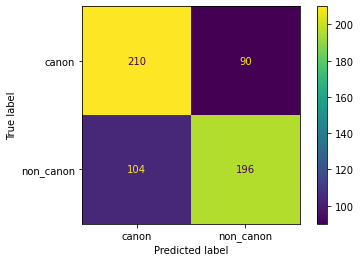

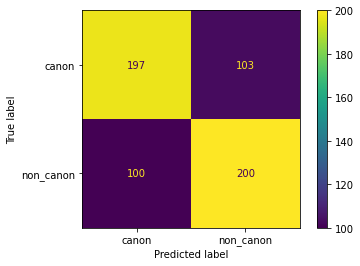

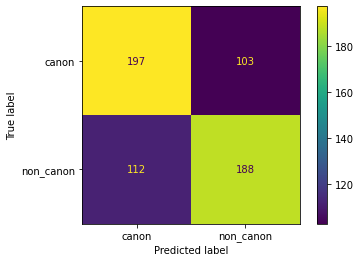

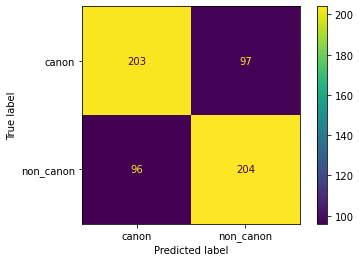

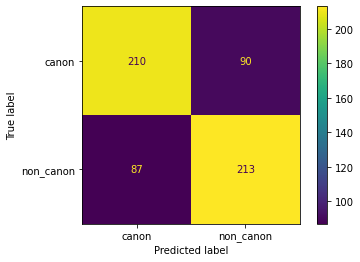

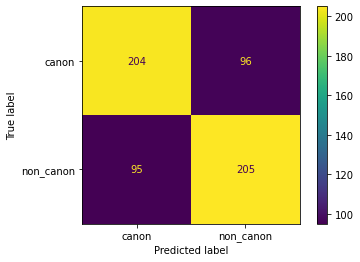

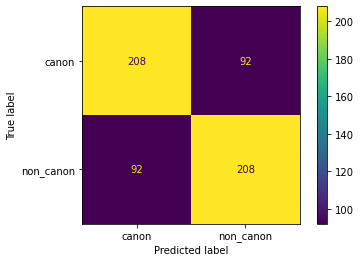

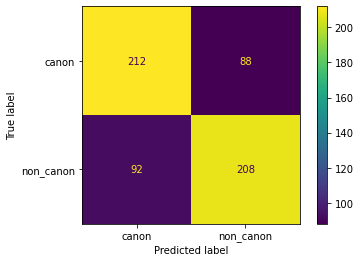

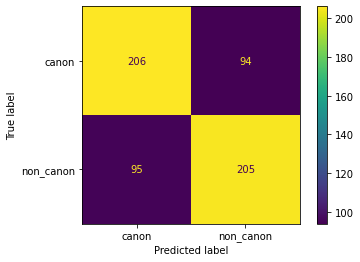

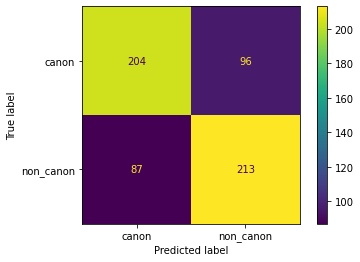

In [42]:
pipe, res, all_bas = N_canonizer_sizeopti(df_doc2vec_novel, N_sample=10, ratio=0.5)

In [68]:
# not better than bow !

0.6877858815894049


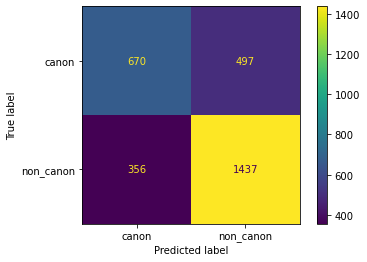

In [43]:
pipe, df_scores, bas = GKF_canonized(df_doc2vec_author)

In [44]:
df_main = pd.read_csv(r'data_doc2vec/spacy_vectors_trained.csv')

In [46]:
df_main.set_index("Unnamed: 0", inplace = True)
df_main = df_main.replace(np.nan, 0)

In [47]:
df_main_author = get_df_with_authors(df_main)

714


In [48]:
df_doc2vec_novel = get_canon_list(df_main_author, df_canon_NOVEL_SCALE)

In [49]:
df_doc2vec_author = get_canon_list(df_main_author, df_canon_AUTEUR_SCALE)

  0%|          | 0/10 [00:00<?, ?it/s]

0.6466666666666667
0.6483333333333333
0.6950000000000001
0.66
0.67
0.6333333333333333
0.6966666666666667
0.6516666666666666
0.6733333333333333
0.655
0.663


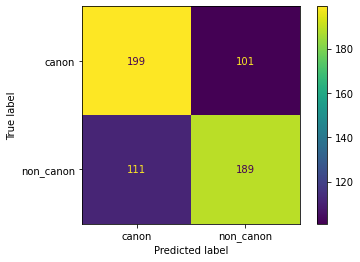

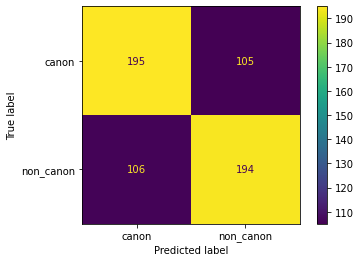

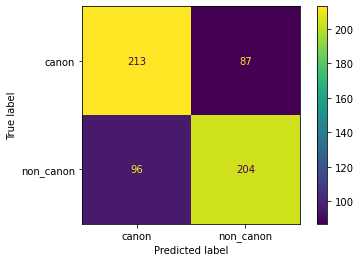

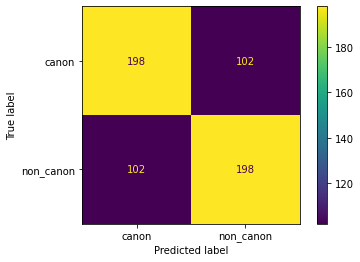

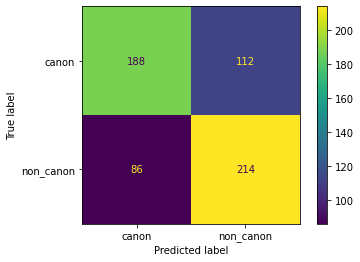

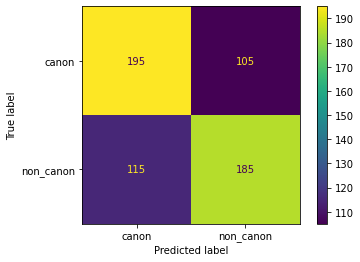

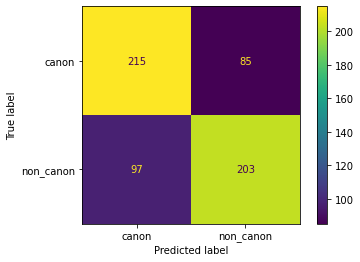

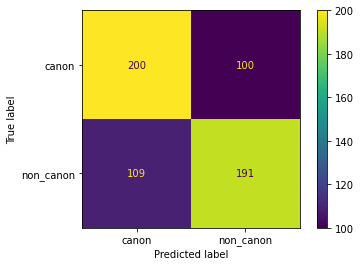

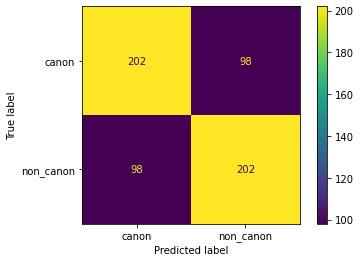

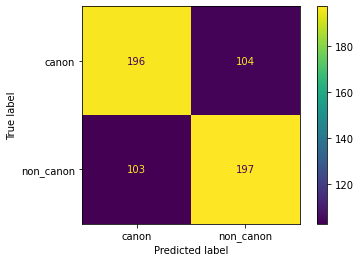

In [50]:
pipe, res, all_bas = N_canonizer_sizeopti(df_doc2vec_novel, N_sample=10, ratio=0.5)

0.6938950436119519


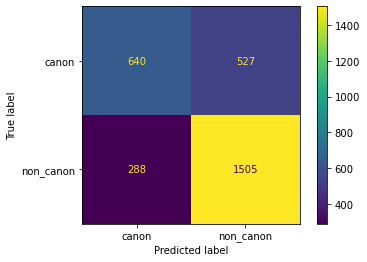

In [51]:
pipe, df_scores, bas = GKF_canonized(df_doc2vec_author)

In [19]:
test = df_unibi_gram_author[df_unibi_gram_author.index == '1972_Simenon-Georges_Maigret-et-Monsieur-Charles']

In [20]:
test

,le,de,un,et,il,avoir,à,lui,être,son,...,faire_pour,le_vérité,mais_à,ça_ne,le_feu,avoir_je,j’_aller,le_nature,canon,auteur
index,,,,,,,,,,,,,,,,,,,,,
1972_Simenon-Georges_Maigret-et-Monsieur-Charles,0.051521,0.042843,0.032653,0.017382,0.028979,0.031324,0.017929,0.024522,0.017929,0.012222,...,0.000026,0.0,0.00013,0.0,0.0,0.000026,0.000104,0.0,canon,Simenon-Georges


In [16]:
test

,le,de,un,et,il,avoir,à,lui,être,son,...,faire_pour,le_vérité,mais_à,ça_ne,le_feu,avoir_je,j’_aller,le_nature,canon,auteur
index,,,,,,,,,,,,,,,,,,,,,
1970_Simenon-Georges_Maigret-et-le-marchand-de-vin,0.04971,0.044901,0.030825,0.017816,0.035749,0.03187,0.018746,0.015006,0.018258,0.011893,...,0.000116,0.000093,0.000046,0.000023,0.000046,0.000046,0.000046,0.000023,canon,Simenon-Georges


In [18]:
test

,le,de,un,et,il,avoir,à,lui,être,son,...,faire_pour,le_vérité,mais_à,ça_ne,le_feu,avoir_je,j’_aller,le_nature,canon,auteur
index,,,,,,,,,,,,,,,,,,,,,
1970_Simenon-Georges_La-folle-de-Maigret,0.050822,0.040945,0.031895,0.017638,0.027856,0.034182,0.018076,0.023063,0.019949,0.00978,...,0.000024,0.000024,0.000073,0.0,0.0,0.000049,0.000219,0.0,canon,Simenon-Georges
